# ExplainableBoostingClassifier - Modified metaparameters

### Import libraries and packages and read processed dataset as *.csv file

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
import pickle


RANDOM_SEED=256

data = pd.read_csv("./dataset/DatasetProcessed.csv")

churn = data.loc[:, data.columns == "Churn"].columns

### Splitting into train and test dataset and preprocessing with StandardScaler from sklearn library

In [39]:
train_cols = data.drop('Churn', axis='columns').columns
X = data[train_cols]
y = data[churn]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED, stratify=y)

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Applying ExplainableBoostingClassifier model with modified metaparameters in model constructor

In [41]:
columns = X.columns.to_list()

In [5]:
%%time
from interpret.glassbox import ExplainableBoostingClassifier
ebm = ExplainableBoostingClassifier(feature_names=columns,random_state=RANDOM_SEED,outer_bags=100, inner_bags=50, max_bins = 500, max_leaves=5)
ebm.fit(X_train, y_train)

CPU times: user 1.08 s, sys: 191 ms, total: 1.27 s
Wall time: 1min 51s


ExplainableBoostingClassifier(feature_names=['gender', 'SeniorCitizen',
                                             'Partner', 'Dependents', 'tenure',
                                             'PhoneService', 'MultipleLines',
                                             'OnlineSecurity', 'OnlineBackup',
                                             'DeviceProtection', 'TechSupport',
                                             'StreamingTV', 'StreamingMovies',
                                             'PaperlessBilling',
                                             'MonthlyCharges', 'TotalCharges',
                                             'PaymentMethod_Bank transfer '
                                             '(automatic)',
                                             'PaymentMethod_Credit card '
                                             '...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'interaction', 'interaction',
                                             'interaction', 'interaction', ...],
                              inner_bags=50, max_bins=500, max_leaves=5,
                              outer_bags=100, random_state=256)

In [42]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

In [43]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

`An example of the explain_global visualisation for importance of the attributes:`

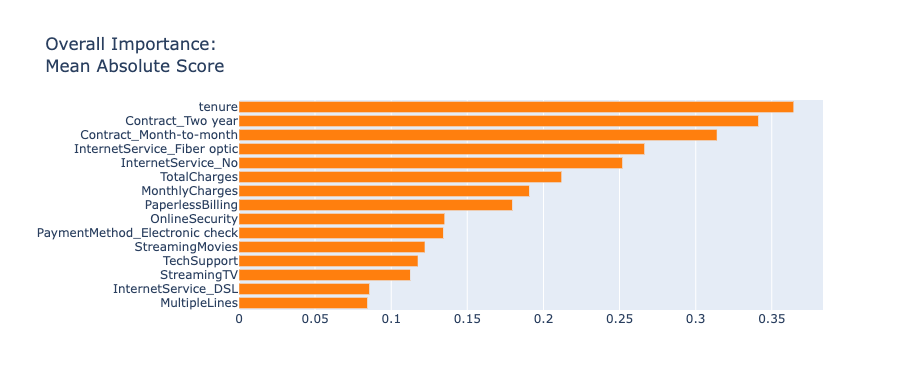

In [44]:
print("Train accuracy score : {}, Test accuracy score : {} ".format(ebm.score(X_train,y_train), ebm.score(X_test,y_test)))

Train accuracy score : 0.8177777777777778, Test accuracy score : 0.8009950248756219 


`Feature-value pairs for each sample from the test dataset were visualized as horizontal bar charts.`

In [45]:
ebm_local = ebm.explain_local(X_test[:50], y_test[:50])
show(ebm_local)

`An example of the explain_local visualisation for the negative target value:`

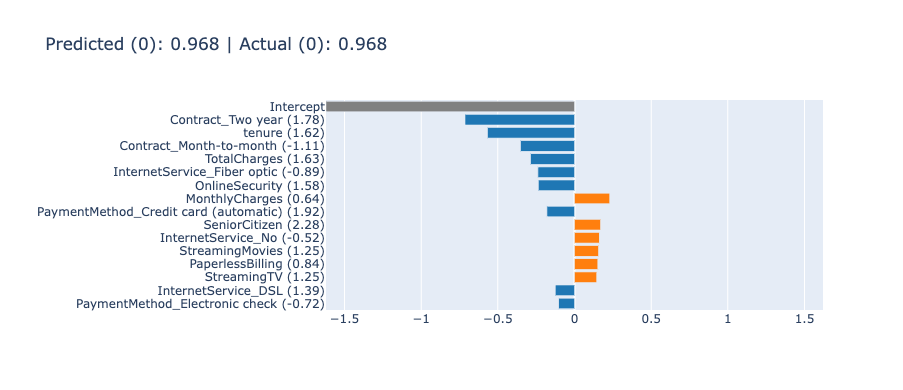

`We can conclude that the attributes "Contract_Two_year" and "tenure" have positive effects for increasing probability of predicting negative target value (0).`

`An example of the explain_local visualisation for the positive target value:`

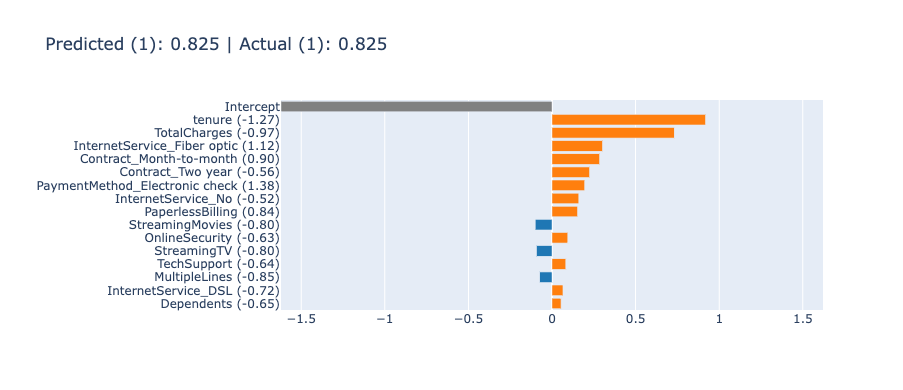

`We can conclude that the attributes "tenure", "InternetService_Fiber optic" and "TotalCharges" have positive effect for increasing probability of predicting positive target values.`

In [46]:
y_predict = ebm.predict(X_test)

In [47]:
type(y_test)

pandas.core.frame.DataFrame

In [59]:
y_test_np = y_test.to_numpy()


In [14]:
type(y_predict)

numpy.ndarray

In [60]:
np.sum(y_predict == y_test_np[0])

1133

In [61]:
np.sum(y_predict != y_test_np[0])

274

In [51]:
type(X_test)

numpy.ndarray

In [52]:
df = pd.DataFrame(X_test, columns = X.columns.to_list())


print(type(df))

<class 'pandas.core.frame.DataFrame'>


`The precision value is higher than classic ExplanableBoostingClassifier by 0.02. The recall has the same value.`

In [62]:
print(metrics.classification_report(y_test_np, y_predict))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.67      0.49      0.57       374

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407



### Confusion matrix

In [63]:
cf_matrix = confusion_matrix(y_test_np, y_predict)

`False positive value for the first model is 98 and for this model is 90. It means that this model is less overfitted then the first one and because of that it is a little bit better than the first one.`

<AxesSubplot:>

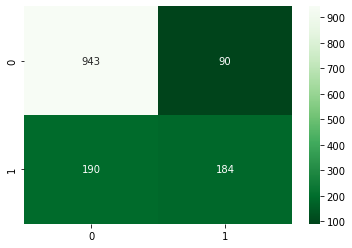

In [34]:
sns.heatmap(cf_matrix, annot=True, fmt='.22g', cmap='Greens_r')


## Saving model and scaler

In [29]:
model_filename = './saved_models/ExplainableBoostingClassifierModel2.model'

with open(model_filename, 'wb') as pickle_file:
    pickle.dump(ebm, pickle_file)
    
scaler_filename = './saved_models/ExplainableBoostingClassifierModel2.scaler'

with open(scaler_filename, 'wb') as pickle_file:
    pickle.dump(scaler, pickle_file)

## Test model for one instance

In [30]:
with open(model_filename, 'rb') as pickle_file:
    model_revived = pickle.load(pickle_file)
    
with open(scaler_filename, 'rb') as pickle_file:
    scaler_revived = pickle.load(pickle_file)

random_index = np.random.randint(0, X_test.shape[0])

instance = X_test[random_index]

instance = instance.reshape(1,26)

print("instance shape : {}".format(instance.shape))

instance = pd.DataFrame(instance, columns=X.columns.to_list())

new_instance_scaled = scaler_revived.transform(instance)
new_value = model_revived.predict(new_instance_scaled)

print("predicted value : {}".format(new_value))

print("true value : {}".format(y_test[random_index]))

instance shape : (1, 26)
predicted value : [0]
true value : [0]
